# Exp9: Use classifiers to assess grammar complexity

In [1]:
import pandas as pd
import spacy

import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import config
sys.path.append('../src')
import models
#import importlib # in case models.py has changed
#importlib.reload(models)

nlp = spacy.load("en_core_web_sm")

/scratch_local/mpb672-5195674/tmp/ipykernel_119163/332399759.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
output_df = pd.read_csv('../dat/cefr_leveled_texts.csv')

In [22]:
df = pd.read_csv('../dat/controlled_text_ranking_info.csv')
df = df.drop_duplicates(subset=['story','label'])

df.groupby("label").agg({"label": lambda x: len(x)})

,label
label,
A1,100
A2,100
B1,100
B2,100
C1,100
C2,100


In [ ]:
print(df.text[19])

In [2]:
df = pd.read_json('../dat/egp_merged.json')
level_models = {level: models.load_model(level, df) for level in ["A1", "A2", "B1", "B2", "C1", "C2"]}

In [3]:
methods = {
    'Static Baseline': 'cefr_leveled_texts.csv',
    #'GPT4': 'controlled_text_gpt4_info.csv',
    #'GPT4 + Description': 'controlled_text_gpt4.csv',
    #'LLM Baseline': 'controlled_text_prompting.csv',
    #'LLM Baseline + Description': 'controlled_text_prompting_info.csv',
    #'Candidate Ranking (Ours)': 'controlled_text_ranking.csv'
    'Candidate Ranking + Description (Ours)': 'controlled_text_ranking_info.csv'
}

In [4]:
def get_sentences(text):
    doc = nlp(text)
    sentences = [token.text.strip() for token in doc.sents]
    return list(sentences)

In [5]:
def get_corresponding_scores(file="cefr_leveled_texts.csv", sample_frac=1, all_levels=True):
    texts = pd.read_csv('../dat/' + file)
    if 'story' in texts.columns: texts = texts.drop_duplicates(subset=['story','label'])
    texts = texts.sample(frac=sample_frac)
    texts["sentences"] = texts.text.apply(get_sentences)
    texts = texts.dropna().explode("sentences")
    for level in texts.label.unique():
        filter = pd.Series(True, index=texts.index) if all_levels else texts['label']==level
        sentences_level = texts.loc[filter, 'sentences']
        print(f'{len(sentences_level)} sentences on level {level}')
        scores = models.get_scores(level_models[level], sentences_level, use_tqdm=True)
        texts.loc[filter, f'{level}_score' if all_levels else 'score'] = scores.float().mean(dim=1).cpu().numpy()
    return texts

In [6]:
def get_score_df(file):
    print(f"Processing {file}")
    texts = get_corresponding_scores(file, sample_frac=1, all_levels=False)
    return texts.groupby("label").agg({"score": "mean"})
    
score_means = {method: get_score_df(file) for method, file in methods.items()}

Processing cefr_leveled_texts.csv
37008 sentences on level B1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:40<00:00, 11.49it/s]


37008 sentences on level B2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:32<00:00, 12.57it/s]


37008 sentences on level C1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:29<00:00, 12.92it/s]


37008 sentences on level A1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:29<00:00, 12.98it/s]


37008 sentences on level C2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:29<00:00, 12.95it/s]


37008 sentences on level A2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:35<00:00, 12.16it/s]


KeyError: "Column(s) ['score'] do not exist"

In [ ]:
#corr_df = texts.groupby("label").agg({f"{level}_score": "mean" for level in level_models.keys()})
#corr_df = texts.groupby("label").agg({"score": "mean"})

In [14]:
for idx, row in texts.sort_values("scores", ascending=False)[['sentences', 'label']].head(20).iterrows():
    print(f'{row.label}: {row.sentences}')

A1: Of course Billy is her best child.
A1: She tells Billy, "You are my best child."
A2: Some guys came up to us because they wanted to play a game of baseball.
A1: Billy always listens to his mother.
A2: My big brother James has always been a good baseball player.
A1: Billy is a good boy.
A1: He always does what she says.
A1: He was carrying a money bag.
B2: Matt is in control but
you can see it takes a real effort.
A1: I would like to see my counselor now.
A1: Billy is a very good boy.
C1: I feel very proud about this place and of the rock art that is here.
B2: Madonna was born in Bay City, Michigan in 1958.
A2: Your arm will be sore for a day.
A2: Your body will hurt for a week.
A2: It is very easy to catch the flu.
A1: Billy is her only child.
B2: The house was an old stucco house that got very hot in the summer and cold in the winter.
A2: You should get a flu shot.
A1: Please make an appointment for next week.


In [28]:
score_means

{'Candidate Ranking + Description (Ours)':           score
 label          
 A1     0.295660
 A2     0.099850
 B1     0.122584
 B2     0.121852
 C1     0.205762
 C2     0.113350}

In [29]:
# Combine and reshape the data
combined_df = pd.concat(score_means).reset_index()
pivot_df = combined_df.pivot(index='level_0', columns='label', values='score')
pivot_df.columns.name=""

pivot_df = pivot_df.map(lambda x: '{:.1f}\%'.format(x * 100))

latex_table = pivot_df.to_latex(column_format="l|r|r|r|r|r|r", escape=False)
print(latex_table)
latex_table_lines = latex_table.splitlines()
data_rows = latex_table_lines[4:5] + [row + "\hline" for row in latex_table_lines[5:-2]]
formatted_latex_table = '\n'.join(latex_table_lines[:1] +latex_table_lines[2:3] +list(reversed(data_rows)) + latex_table_lines[-1:])
print(formatted_latex_table.replace("C2 \\", "C2 \\\\\hline").replace("\\hline\n\hline", "\hline"))

\begin{tabular}{l|r|r|r|r|r|r}
\toprule
 & A1 & A2 & B1 & B2 & C1 & C2 \\
level_0 &  &  &  &  &  &  \\
\midrule
Candidate Ranking + Description (Ours) & 29.6\% & 10.0\% & 12.3\% & 12.2\% & 20.6\% & 11.3\% \\
\bottomrule
\end{tabular}

\begin{tabular}{l|r|r|r|r|r|r}
 & A1 & A2 & B1 & B2 & C1 & C2 \\\hline\
Candidate Ranking + Description (Ours) & 29.6\% & 10.0\% & 12.3\% & 12.2\% & 20.6\% & 11.3\% \\\hline
\midrule
\end{tabular}


In [13]:
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 14, 'xtick.labelsize': 12,
                     'ytick.labelsize': 12, 'legend.fontsize': 14}) 
def to_percent(y, position):
    return f"{100 * y:.0f}%"

In [8]:
methods = {
    'Static labeled text': 'cefr_leveled_texts.csv',
    'Ranking-based text generation': 'controlled_text_ranking_info.csv'
}

def get_df(file='controlled_text_ranking.csv'):
    texts = get_corresponding_scores(file, sample_frac=1, all_levels=True)
    corr_df = texts.groupby("label").agg({f"{level}_score": "mean" for level in level_models.keys()})
    return corr_df.rename(columns=lambda x: x.replace("_score", ""))

corr_dfs = {label: get_df(file) for label, file in methods.items()}

37008 sentences on level C2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:27<00:00, 13.18it/s]


37008 sentences on level A1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:28<00:00, 13.02it/s]


37008 sentences on level C1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:29<00:00, 12.92it/s]


37008 sentences on level A2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:35<00:00, 12.14it/s]


37008 sentences on level B1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:39<00:00, 11.66it/s]


37008 sentences on level B2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:32<00:00, 12.54it/s]


7985 sentences on level C1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 13.03it/s]


7985 sentences on level B2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.58it/s]


7985 sentences on level A1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 13.04it/s]


7985 sentences on level A2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.28it/s]


7985 sentences on level B1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.78it/s]


7985 sentences on level C2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.99it/s]


In [11]:
corr_dfs['Static labeled text'].to_json("../doc/baseline_levels.json")

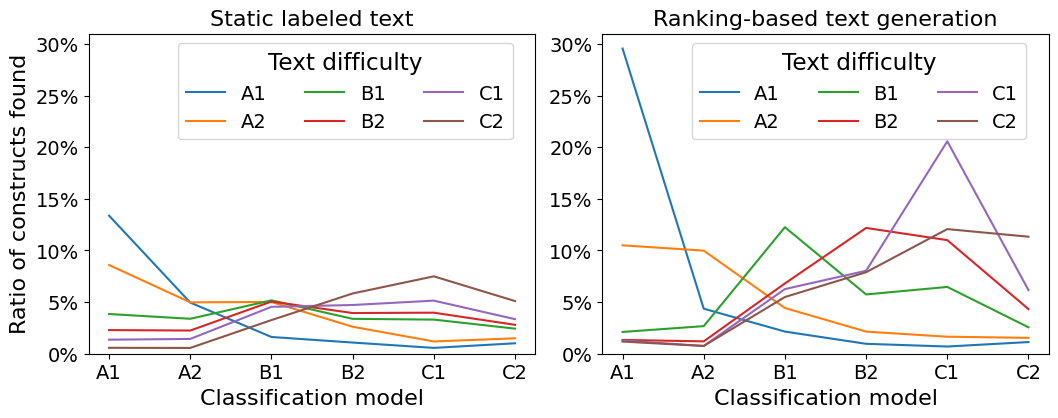

In [29]:
plt.rcParams.update({'font.size': 20, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14, 'legend.fontsize': 14}) 
plt.rcParams['legend.title_fontsize'] = 'small'
def plot_all_levels(corr_df, axis, title_label="ranking-based"):    
    df_sorted = corr_df.sort_index(axis=1)
    for label in df_sorted.index:
        axis.plot(df_sorted.columns, df_sorted.loc[label, :], label=label)
    
    axis.set_xlabel('Classification model')
    axis.set_ylabel('Ratio of constructs found')
    axis.set_title(f'{title_label}')
    axis.yaxis.set_major_formatter(FuncFormatter(to_percent))
    axis.set_ylim(0, 0.31)  # Replace lower_limit and upper_limit with your desired values
    axis.legend(title="Text difficulty", loc='upper center', bbox_to_anchor=(0.575, 1), ncol=len(df_sorted.index)/2)

legends = []
# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# After creating subplots, adjust the spacing around subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.3)

for idx, (label, corr_df) in enumerate(corr_dfs.items()):
    plot_all_levels(corr_df, axes[idx], label)
axes[1].set_ylabel('')

plt.savefig(f'../doc/all_levels.pdf', transparent=True, bbox_inches='tight')
plt.show()